<h1><center>Polio cases analysis and predictions</center></h1>
Authors:<br>
- Filip Olszowski, 302891<br>
- Szymon Lis 302871, 

<h3>Introduction</h3>
<div style="  text-align: justify; text-justify: inter-word;">
Data analysis for given set of measurements can be very helpful to understand certain phenomenons from found correlations. However, another use of statistic modeling is to create a model from given samples and make predictions from it. In our project, we created two models with the same parameters to compare differences and see how different approaches lead to different results. 
Topic of our project is Polio disease, specifically paralysis cases. We will make predictions for three diferent time slots to see how models behave with different sets of data<br>

<b>Polio descripion:</b><br>
Poliomyelitis commonly shortened to polio, is an infectious disease caused by the poliovirus. In about 0.5 percent of cases, it moves from the gut to affect the central nervous system, and there is muscle weakness resulting in a flaccid paralysis. This can occur over a few hours to a few days. The weakness most often involves the legs, but may less commonly involve the muscles of the head, neck, and diaphragm. Many people fully recover. In those with muscle weakness, about 2 to 5 percent of children and 15 to 30 percent of adults die. Up to 70 percent of those infected have no symptoms. Another 25 percent of people have minor symptoms such as fever and a sore throat, and up to 5 percent have headache, neck stiffness, and pains in the arms and legs. These people are usually back to normal within one or two weeks. Years after recovery, post-polio syndrome may occur, with a slow development of muscle weakness similar to that which the person had during the initial infection.
<h6>Source: https://en.wikipedia.org/wiki/Polio </h6>
</div>

<h4>Imports:</h4>

In [1]:
from cmdstanpy import CmdStanModel, CmdStanMCMC
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

global_seed = 29042020

<h4>Used functions</h4>

In [2]:
def select_data(country: str, n_last_years: int = None) -> pd.DataFrame:
    import_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
    selected_data = {}
    if n_last_years:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][-n_last_years-1:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][-n_last_years-1:-1].to_numpy().flatten()
    else:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][:-1].to_numpy().flatten()
    return selected_data

def plot_selected_data(selected_data: pd.DataFrame) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.legend(['Total (reported) polio cases for selected data'], prop={'size': 20})
    plt.xlabel('Year')
    plt.ylabel('Number of cases')
    plt.title(f'Data for the last {len(selected_data["Year"])} years')
    plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
    plt.show()
    
def plot_distributions(fitted_model: CmdStanMCMC) -> None:
    plt.figure(figsize=(26, 6))
    plt.grid(True)
    plt.subplot(131)
    plt.hist(fitted_model.stan_variable('alpha'), bins = 30, density = True)
    plt.title('Alpha distribution')
    plt.subplot(132)
    plt.hist(fitted_model.stan_variable('beta'), bins = 30, density = True)
    plt.title('Beta distribution')
    plt.subplot(133)
    plt.hist(fitted_model.stan_variable('sigma'), bins = 30, density = True)
    plt.title('Sigma distribution')
    plt.show()
    
def plot_predictions_chart(selected_data: pd.DataFrame, pred_variable: np.ndarray, pred_year: int|str, type: str ,quantiles: bool = True) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.plot([pred_year-1, pred_year], [selected_data['Cases'][-1], int(np.mean(pred_variable))], linewidth=5)
    if quantiles:
        plt.scatter(pred_year,np.quantile(pred_variable,0.95), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.75), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.5), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.25), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.05), linewidth=0.5)
        plt.legend(['Total polio cases [imported data]','Total predicted polio cases', 'Quantile 0.95', 'Quantile 0.75','Quantile 0.5','Quantile 0.25','Quantile 0.05'], prop={'size': 20})
    else:
        plt.legend(['Total polio cases [imported data]','Total predicted polio cases'], prop={'size': 20})
    plt.title(f'Model chart with predicted data using {type} model')
    plt.show()
    print(f'Predicted mean value of Polio cases for year {pred_year}: {int(np.mean(pred_variable))}')

<h3>Importing world data</h3>

Imported data is in CSV format, and we extracted data of our interest to pandas dataframe

Source: https://ourworldindata.org/polio 

In [3]:
imported_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
world_data = imported_data[imported_data['Entity'] == 'World'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]  #2021 data is incomplete
world_data.reset_index(inplace=True)
world_data.describe()

,index,Year,Total (reported) polio cases,Total (estimated) polio cases
count,41.000000,41.000000,41.000000,41.000000
mean,7642.000000,2000.000000,13153.390244,87584.902439
std,11.979149,11.979149,17926.259126,126481.340420
min,7622.000000,1980.000000,42.000000,49.000000
25%,7632.000000,1990.000000,784.000000,1139.000000
50%,7642.000000,2000.000000,2971.000000,20797.000000
75%,7652.000000,2010.000000,23053.000000,131538.000000
max,7662.000000,2020.000000,65737.000000,460159.000000


<h3>World trends</h3>

Looking at global data from the past 40 years it seems that polio was successfully stopped, hoever, closer inspection to the past few years is necessary to understand growing problem.

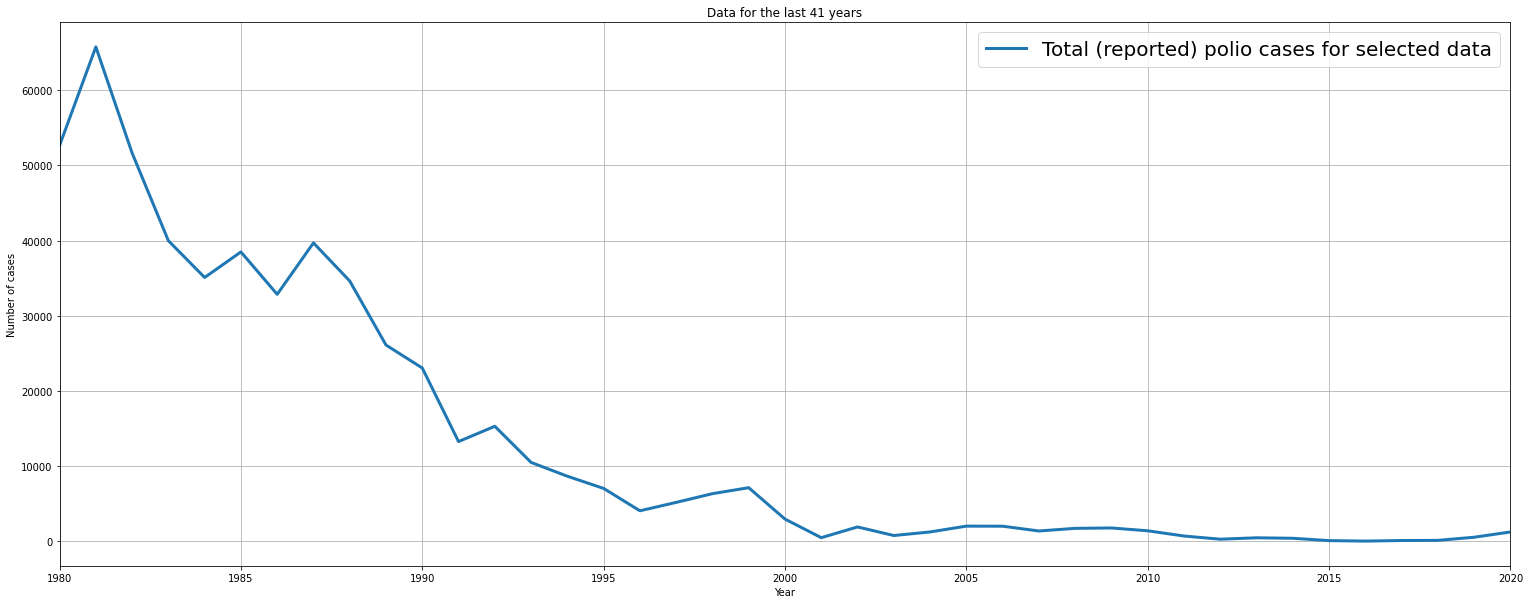

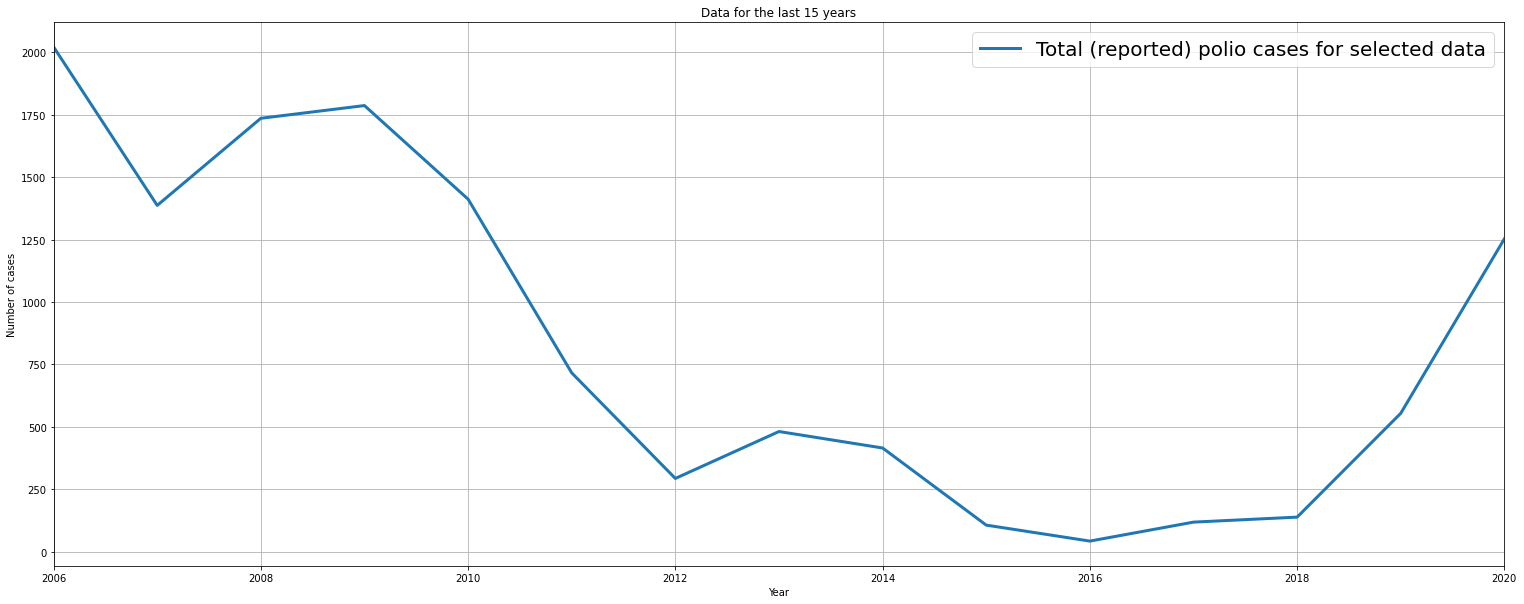

In [4]:
selected_world_data = select_data('World')
plot_selected_data(selected_world_data)

selected_world_data = select_data('World', 15)
plot_selected_data(selected_world_data)

As it can be seen in selected period of time, polio is growing rather than being eradicated 

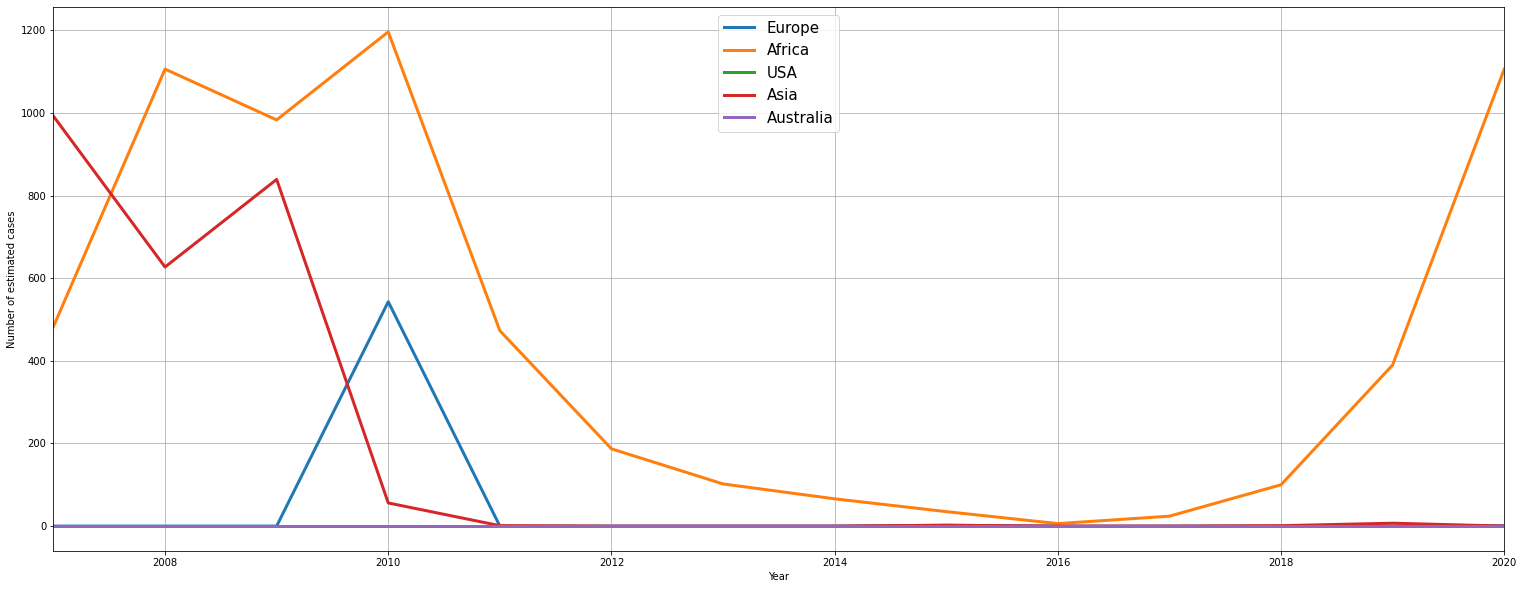

In [5]:
europe_selected_data = imported_data[imported_data['Entity'] == 'Europe'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
africa_selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
states_selected_data = imported_data[imported_data['Entity'] == 'United States'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
asia_selected_data = imported_data[imported_data['Entity'] == 'South-East Asia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
australia_selected_data = imported_data[imported_data['Entity'] == 'Australia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(europe_selected_data['Year'],europe_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(africa_selected_data['Year'],africa_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(states_selected_data['Year'],states_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(asia_selected_data['Year'],asia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(australia_selected_data['Year'],australia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Europe','Africa','USA','Asia','Australia'], prop={'size': 15})
plt.xlabel('Year')
plt.ylabel('Number of estimated cases')
plt.xlim(min(europe_selected_data['Year']),max(europe_selected_data['Year']))
plt.show()

As it can be seen, the problem is growing rapidly in Africa. So we will make predictions for Africa continent as it is currently most interesting to predict further development of paralytic cases of polio.

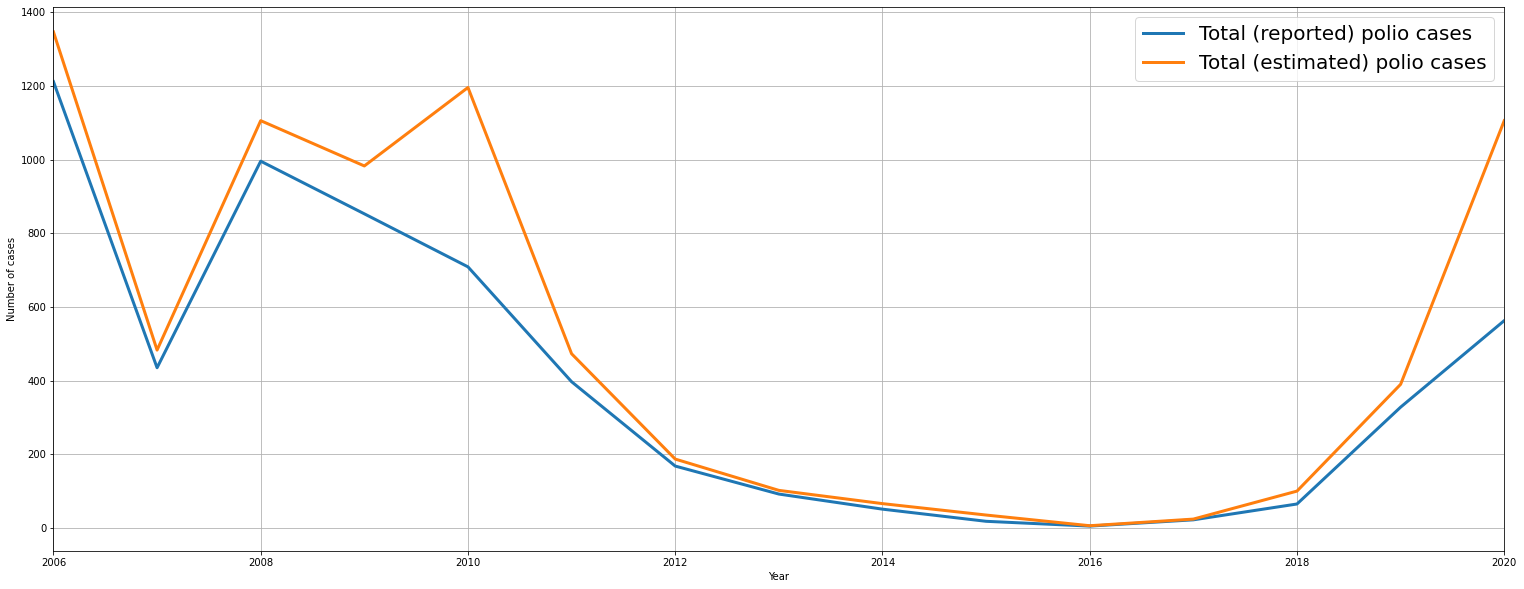

In [6]:
# Selecting data for analysis
n_years = 15
selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-n_years-1:-1]
selected_data.rename(columns = {'Total (reported) polio cases': 'Cases'}, inplace=True)
selected_data.rename(columns= {'Total (estimated) polio cases':'Cases_estimated'}, inplace=True)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
plt.plot(selected_data['Year'],selected_data['Cases_estimated'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
plt.show()

<h3>Model 1 - Linear regression</h3>
For first model linear regression will be used as it is most commonly programmed.

In [7]:
stan_file = "stan_models\\linear_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int <lower = 0> N; 
    vector [N] y; //cases
    vector [N] x; //years
    int x_pred; //predicted year
} 
parameters { 
    real alpha; 
    real beta; 
    real mu;
    real <lower = 0> sigma; 
} 
model { 
    alpha ~ normal(0,10); 
    beta ~ normal(0,10);  //From research 
    sigma ~ exponential(1);
    y ~ normal(alpha + beta * x, sigma);
} 
generated quantities{ 
    vector[N] log_lik;
    for(i in 1:N){
        log_lik[i] = normal_lpdf(y[i]|mu, sigma);
    }
    real y_pred = normal_rng(alpha + beta * x_pred , sigma);
} 


INFO:cmdstanpy:found newer exe file, not recompiling


Predictions for thew whole avaiable data

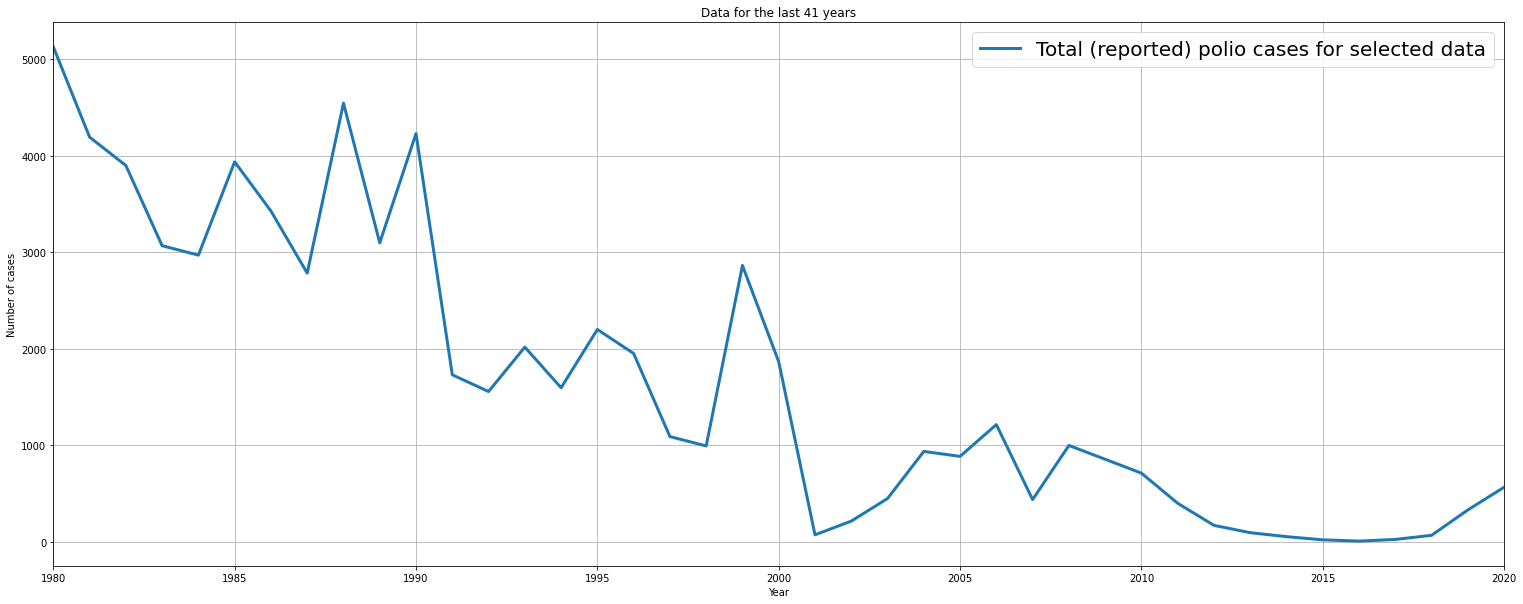

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [8]:
selected_data_whole = select_data('Africa')
plot_selected_data(selected_data_whole)

model_data_dict = {'N': len(selected_data_whole['Year']),
                    'x': selected_data_whole['Year'],
                    'y': selected_data_whole['Cases'],
                    'x_pred': selected_data_whole['Year'][-1] + 1
                  }

fit_linear_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)

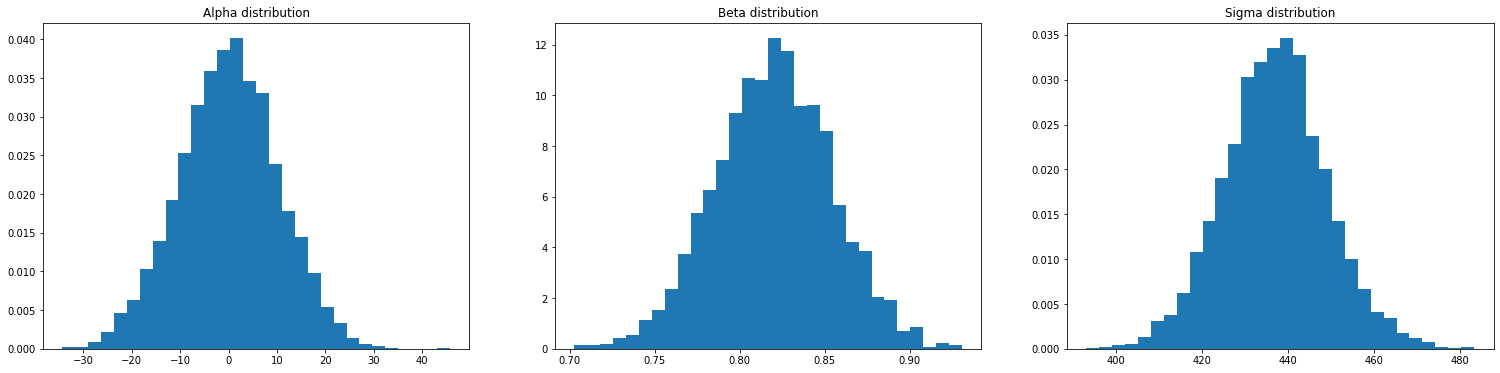

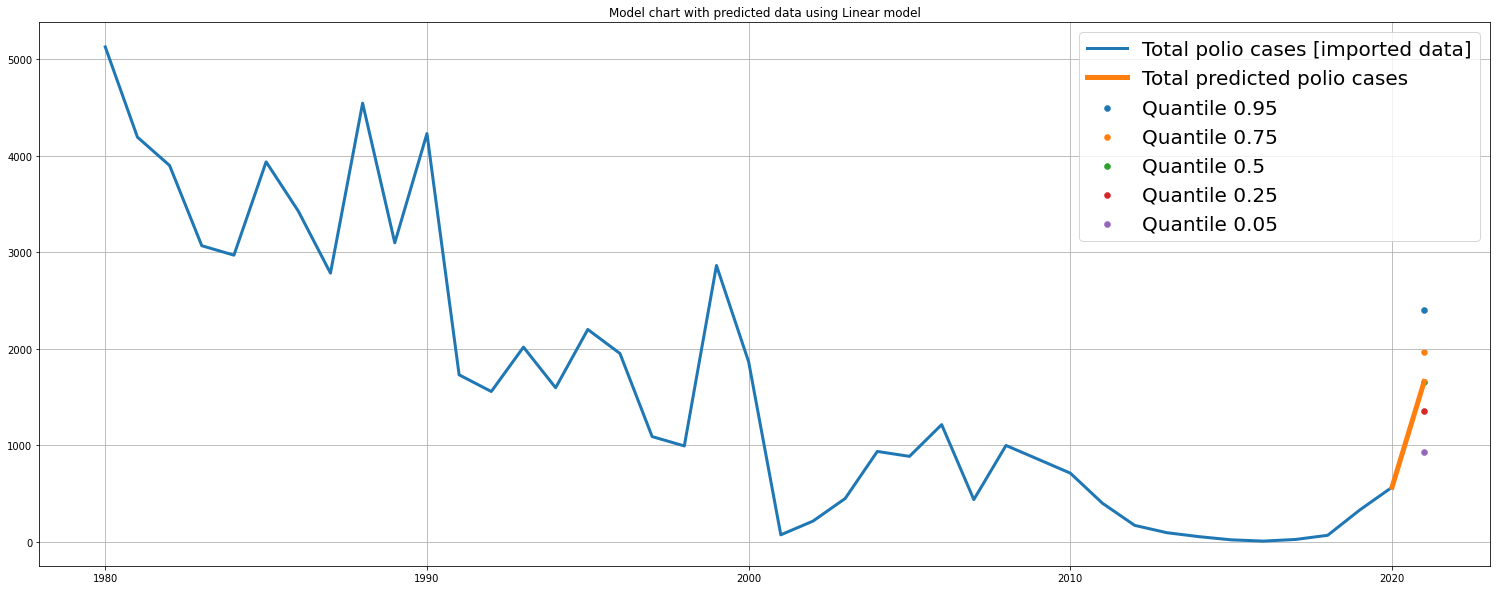

Predicted mean value of Polio cases for year 2021: 1658


In [9]:
plot_distributions(fitted_model=fit_linear_whole)
plot_predictions_chart(selected_data_whole, fit_linear_whole.stan_variable('y_pred'), 2021, type='Linear')

Predictions for last decade

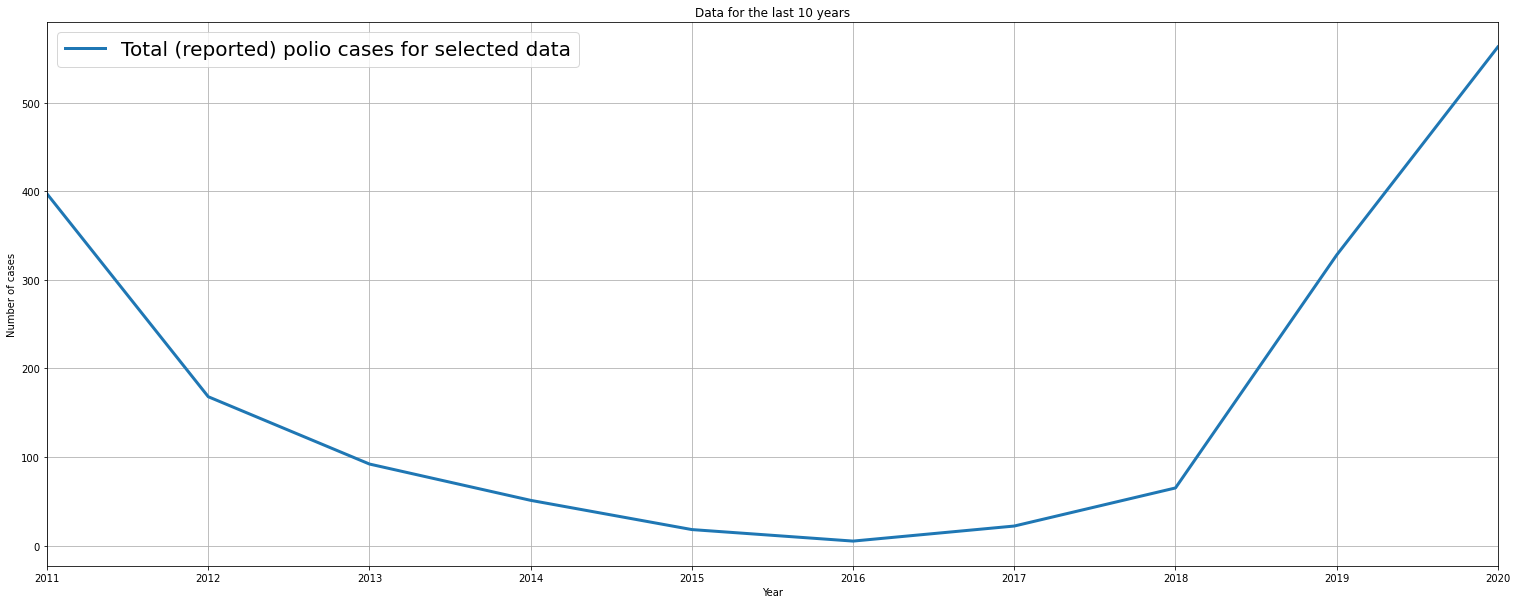

In [10]:
selected_data_decade = select_data('Africa', 10)
plot_selected_data(selected_data_decade)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


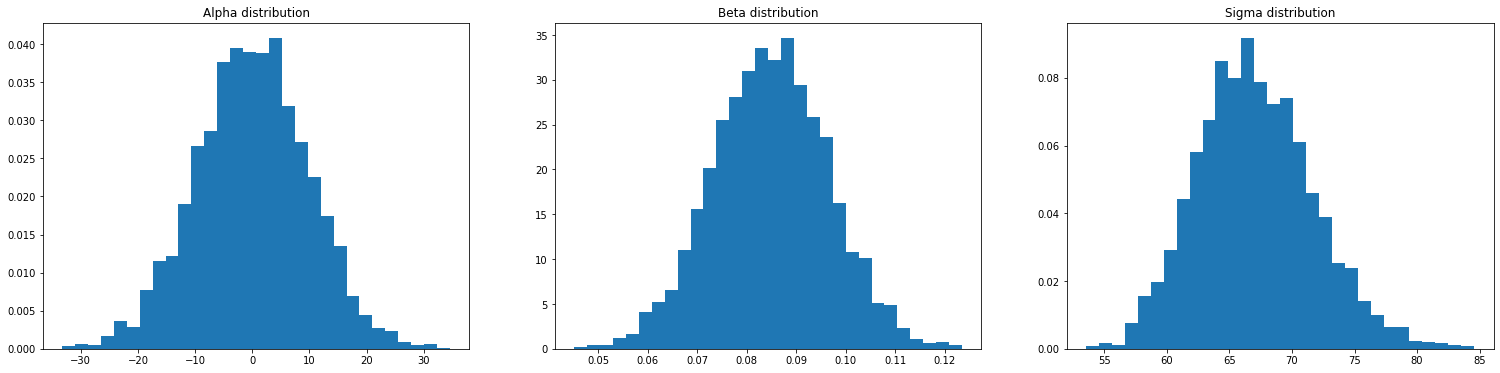

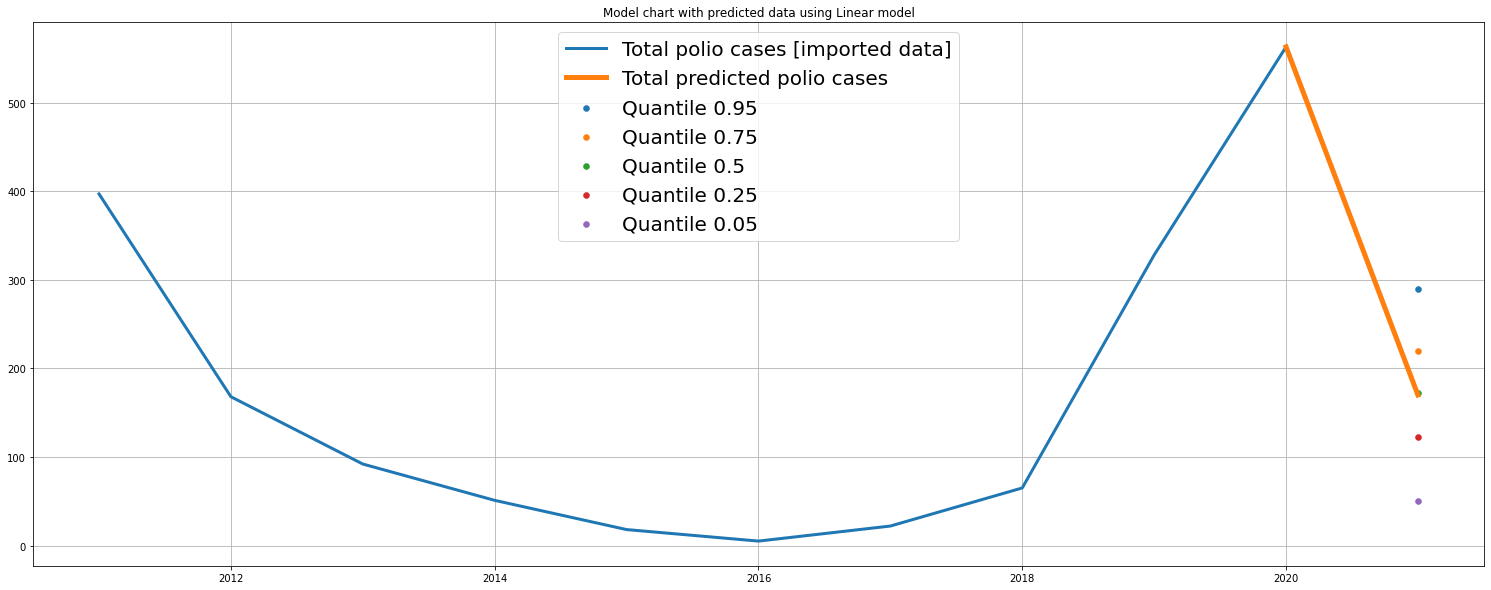

Predicted mean value of Polio cases for year 2021: 170


In [11]:
model_data_dict = {'N': len(selected_data_decade['Year']),
                    'x': selected_data_decade['Year'],
                    'y': selected_data_decade['Cases'],
                    'x_pred': selected_data_decade['Year'][-1] + 1,
                  }


fit_linear_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_decade)
plot_predictions_chart(selected_data_decade, fit_linear_decade.stan_variable('y_pred'), 2021, type='Linear')

Predictions for last 5 years (growths)

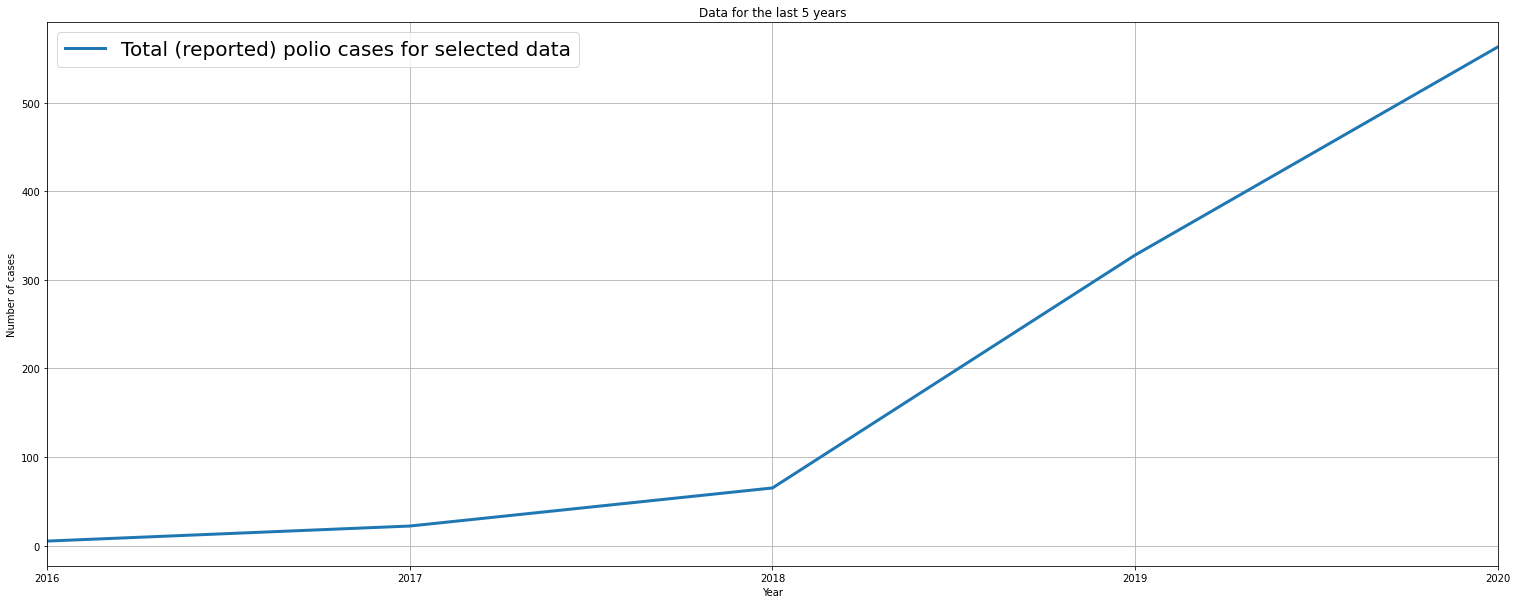

In [12]:
selected_data_growths = select_data('Africa', 5)
plot_selected_data(selected_data_growths)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


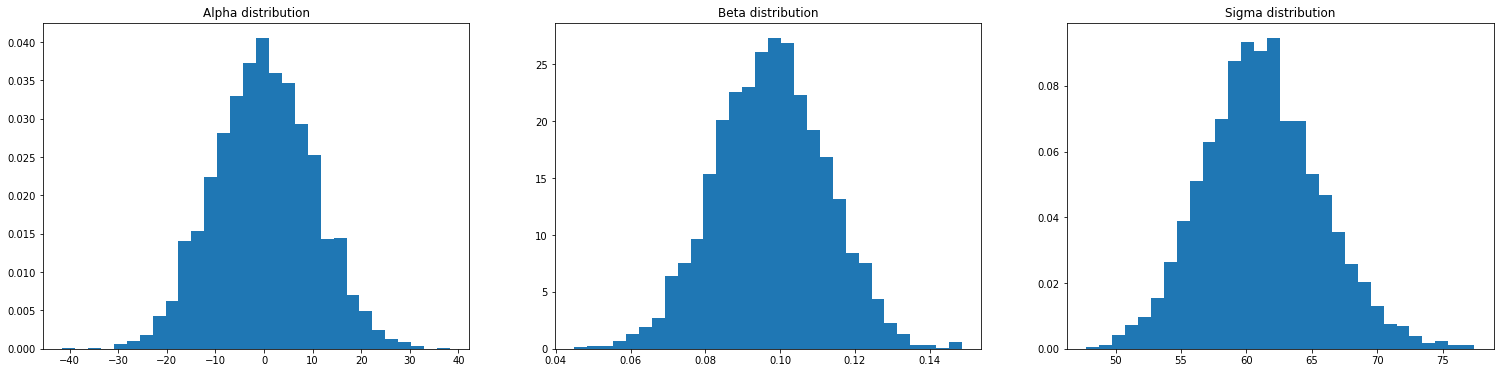

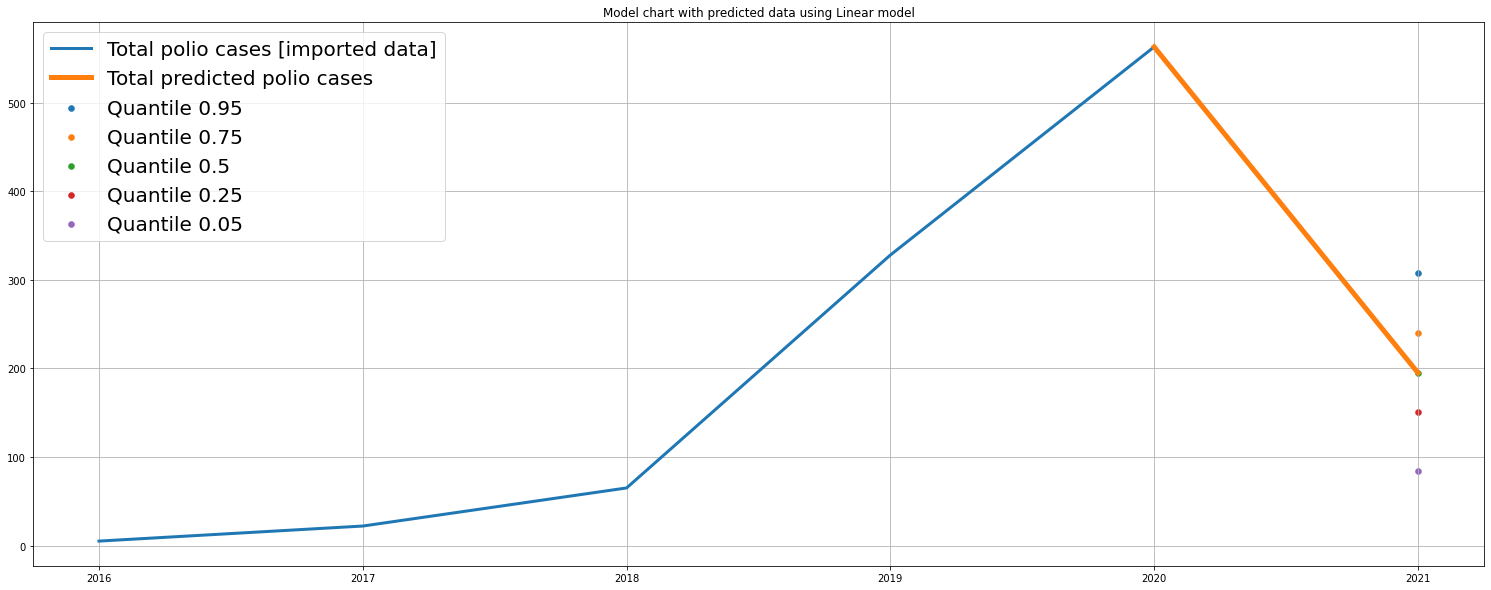

Predicted mean value of Polio cases for year 2021: 195


In [13]:
model_data_dict = {'N': len(selected_data_growths['Year']),
                    'x': selected_data_growths['Year'],
                    'y': selected_data_growths['Cases'],
                    'x_pred': selected_data_growths['Year'][-1] + 1,
                  }

fit_linear_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_growths)
plot_predictions_chart(selected_data_growths, fit_linear_growths.stan_variable('y_pred'), 2021, type='Linear')

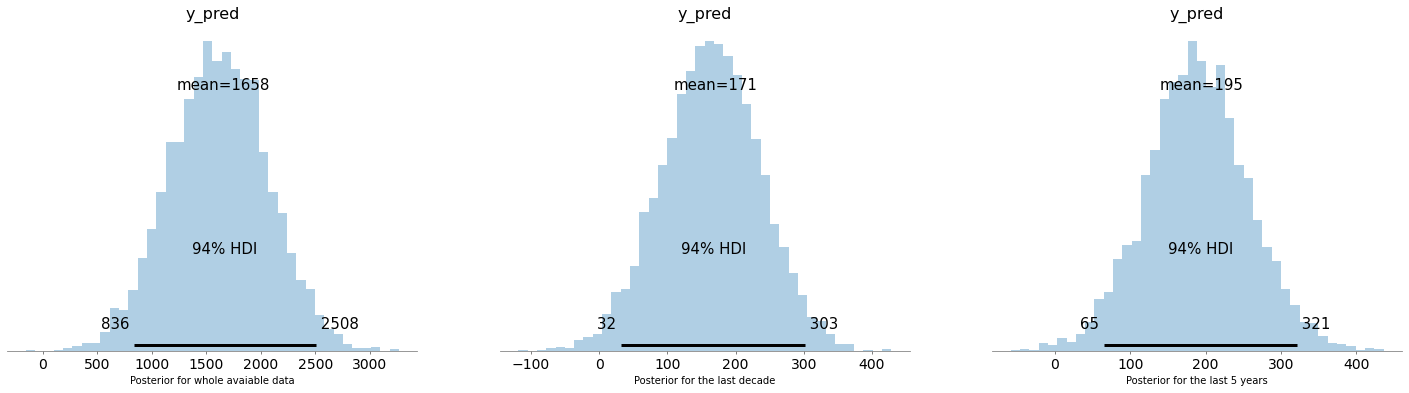

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

<h2>Model 2 - Autoregressive</h2>
As diesese is strictly connected with active infected people first model will be created on basis of autoregression.
<h6>Reference: https://mc-stan.org/docs/2_23/stan-users-guide/autoregressive-section.html</h6>

In [15]:
stan_file = "stan_models\\autoregressive_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
  int <lower = 0> N; 
  vector [N] y; 
} 
 
parameters { 
  real alpha; 
  real beta;
  real mu;
  real <lower = 0> sigma; 
} 
model { 
  alpha ~ normal(0,10); 
  beta ~ normal(0,10);  //From research 
  sigma ~ exponential(1);
  for (n in 2:N){
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
  }
} 
generated quantities{ 
  vector[N] log_lik;
  for(i in 1:N){
      log_lik[i] = normal_lpdf(y[i] | mu, sigma);
  }
  real y_pred = normal_rng(alpha + beta * y[N], sigma); 
} 



INFO:cmdstanpy:found newer exe file, not recompiling


Fitting model to whole avaiable data

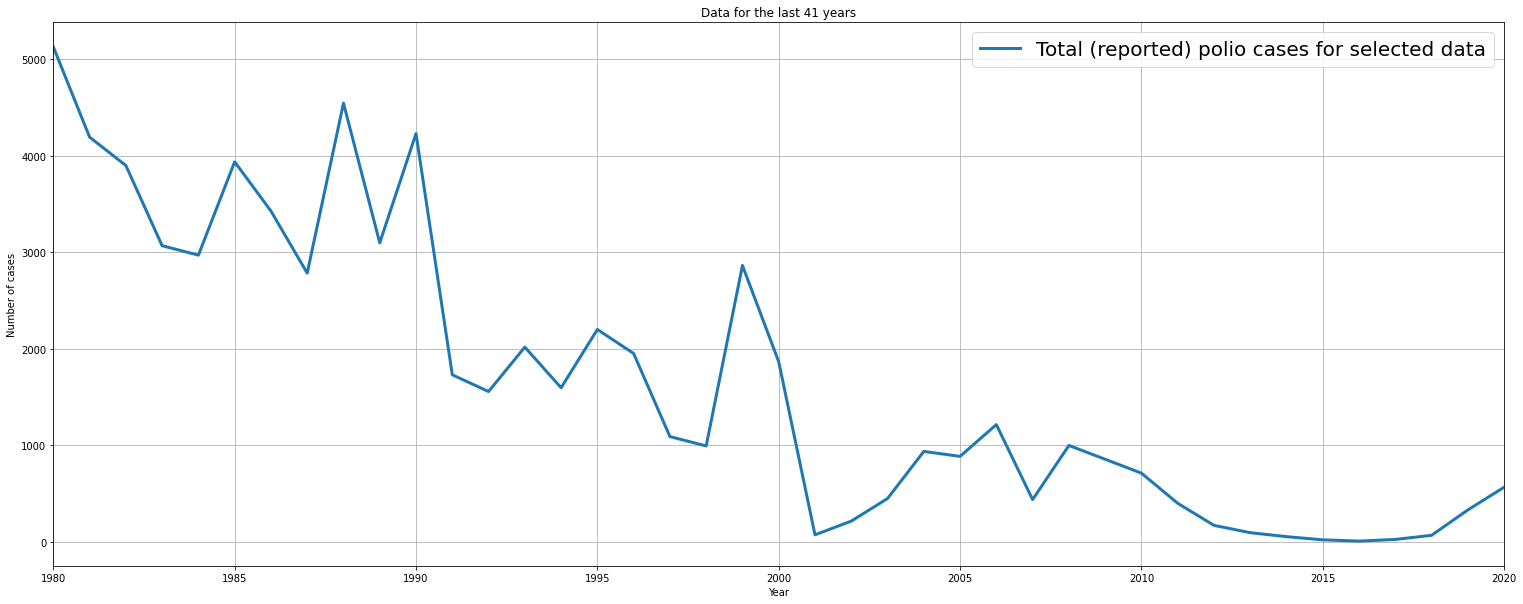

In [16]:
plot_selected_data(selected_data_whole)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


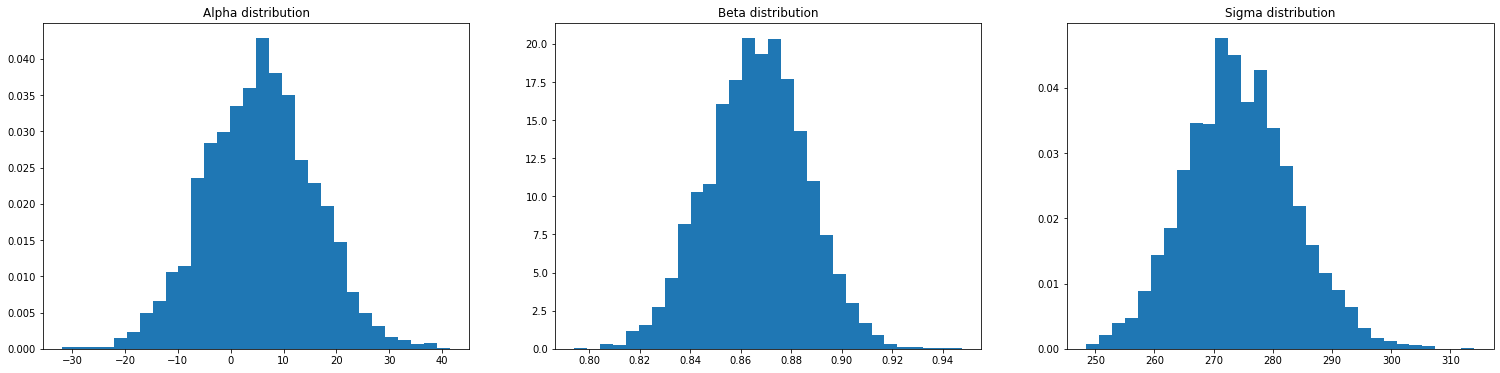

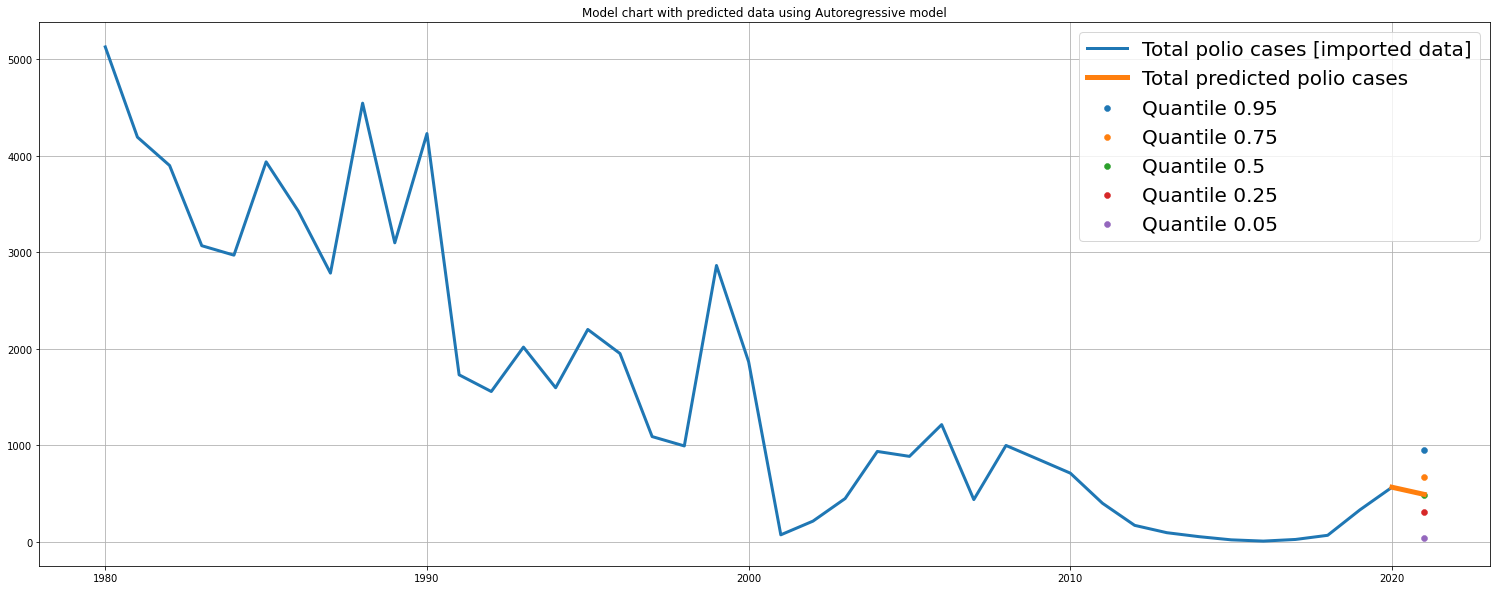

Predicted mean value of Polio cases for year 2021: 489


In [17]:
model_data_dict = {'N': len(selected_data_whole['Year']),
                    'x': selected_data_whole['Year'],
                    'y': selected_data_whole['Cases'],
                    'x_pred': selected_data_whole['Year'][-1] + 1,
                  }

fit_autoregressive_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_whole)
plot_predictions_chart(selected_data_whole, fit_autoregressive_whole.stan_variable('y_pred'), 2021, type='Autoregressive')

Predictions for last decade

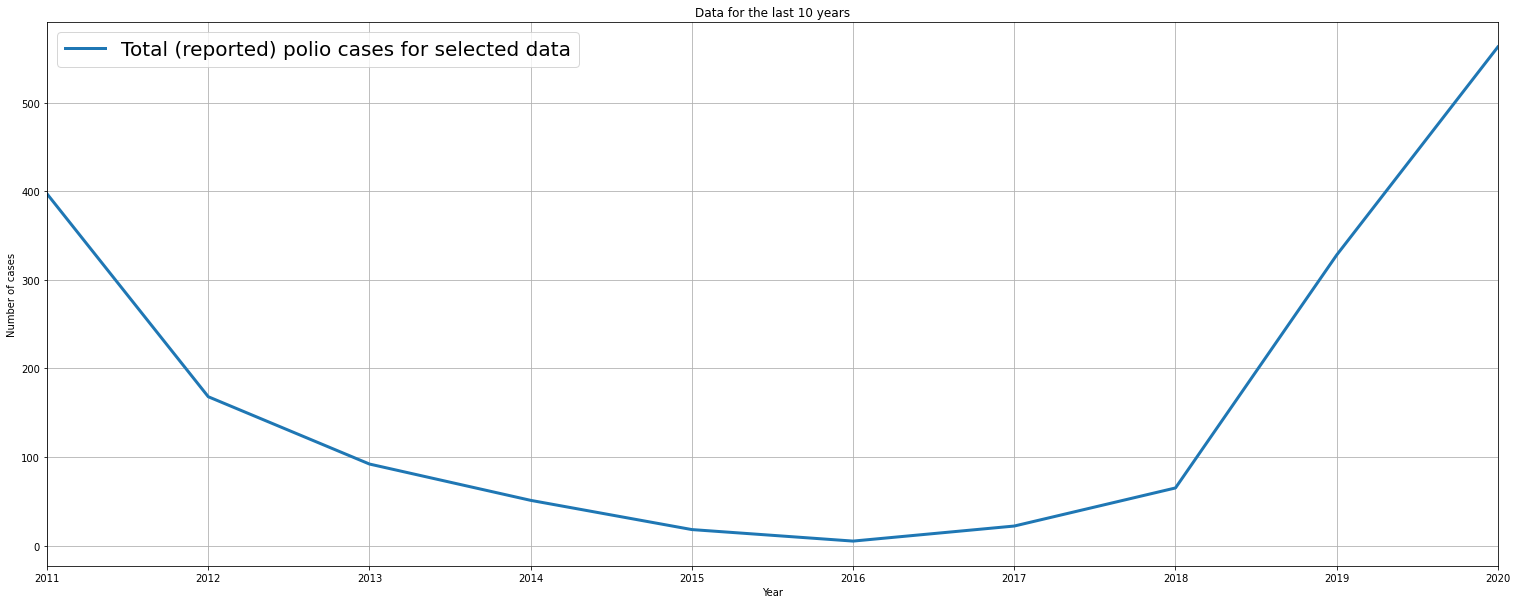

In [18]:
plot_selected_data(selected_data_decade)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


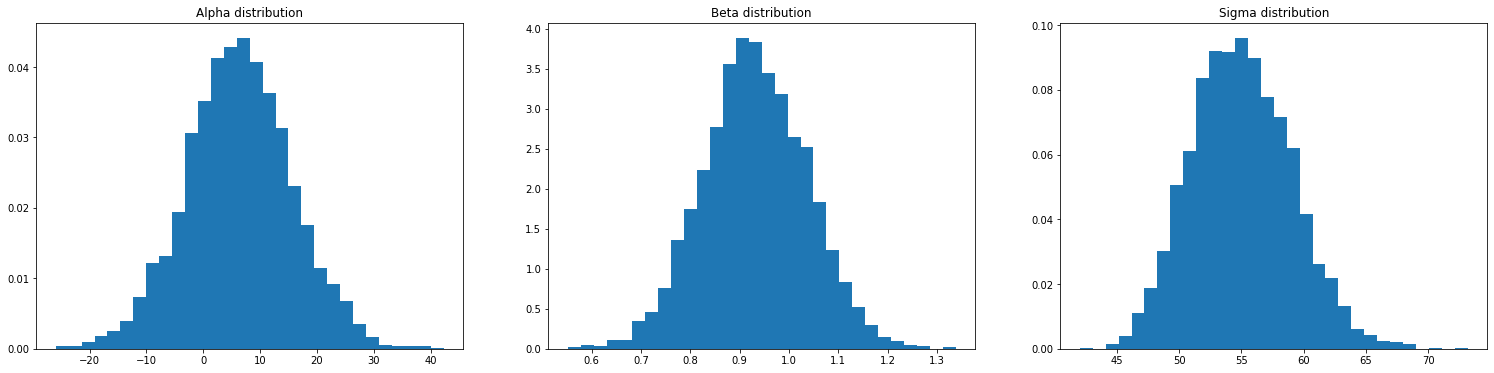

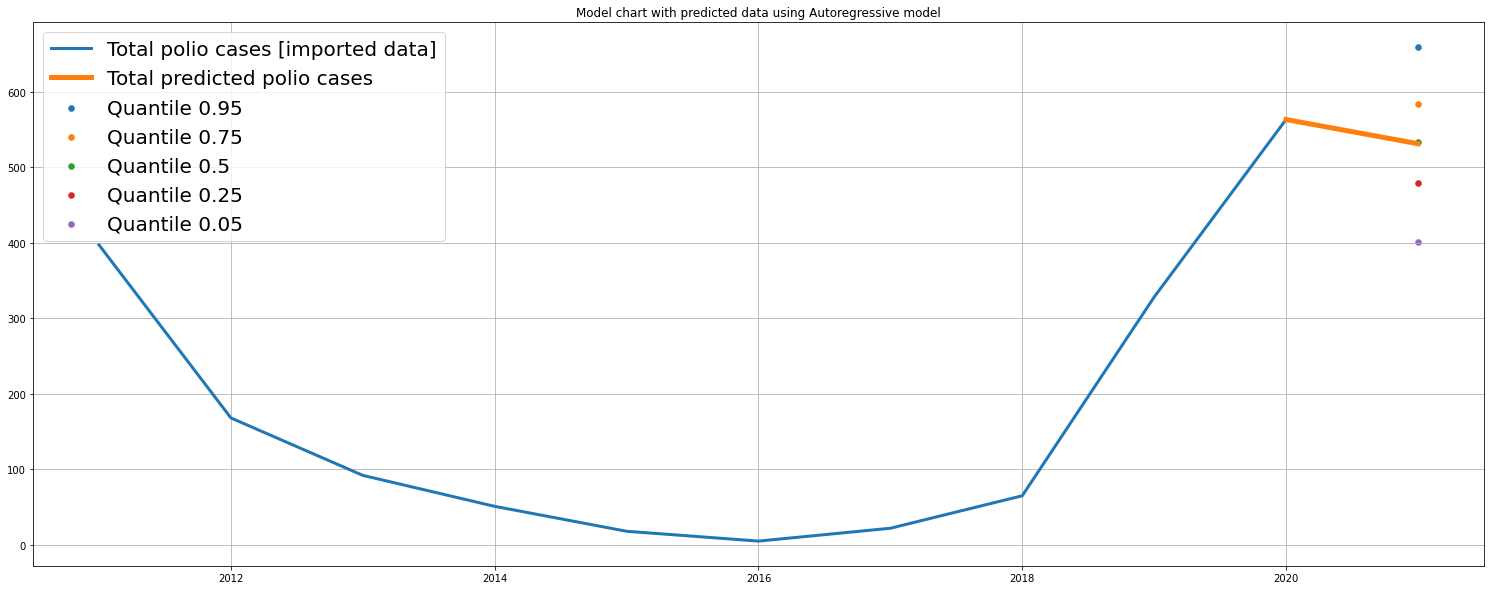

Predicted mean value of Polio cases for year 2021: 531


In [19]:
model_data_dict = {'N': len(selected_data_decade['Year']),
                    'x': selected_data_decade['Year'],
                    'y': selected_data_decade['Cases'],
                    'x_pred': selected_data_decade['Year'][-1] + 1,
                  }

fit_autoregressive_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_decade)
plot_predictions_chart(selected_data_decade, fit_autoregressive_decade.stan_variable('y_pred'), 2021, type='Autoregressive')

Predictions for last 5 years (growths)

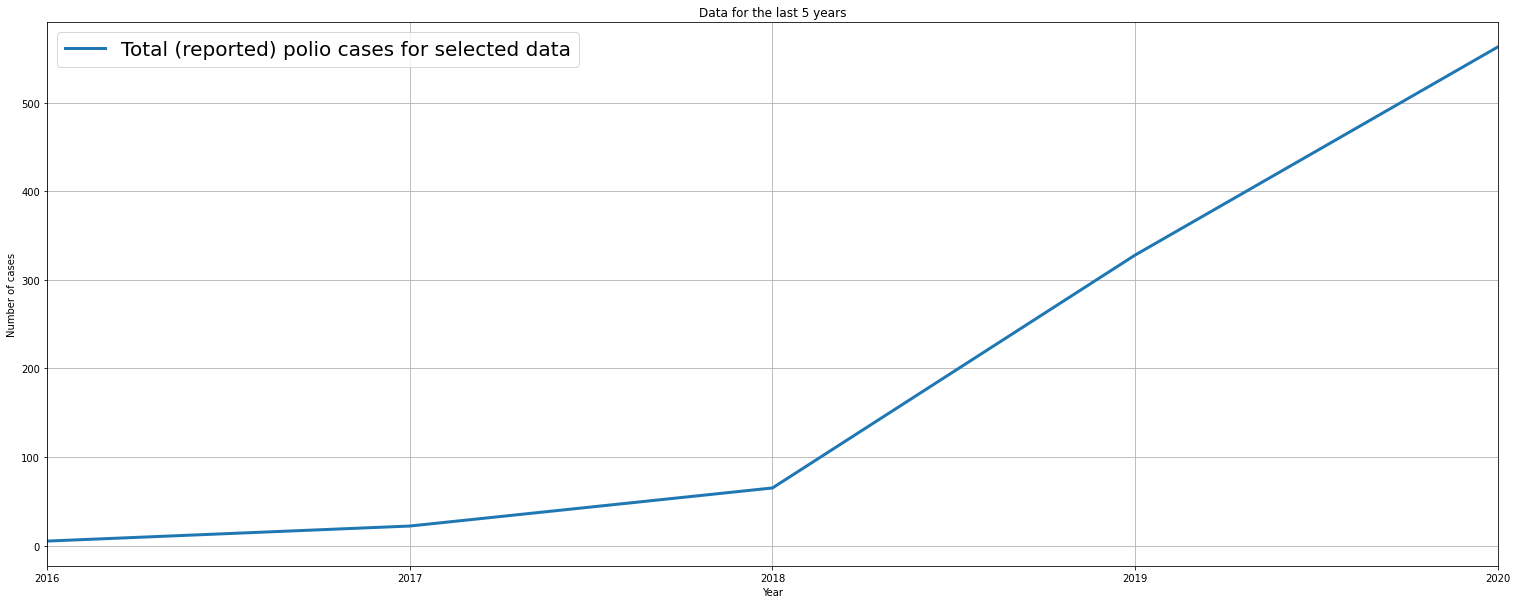

In [20]:
plot_selected_data(selected_data_growths)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


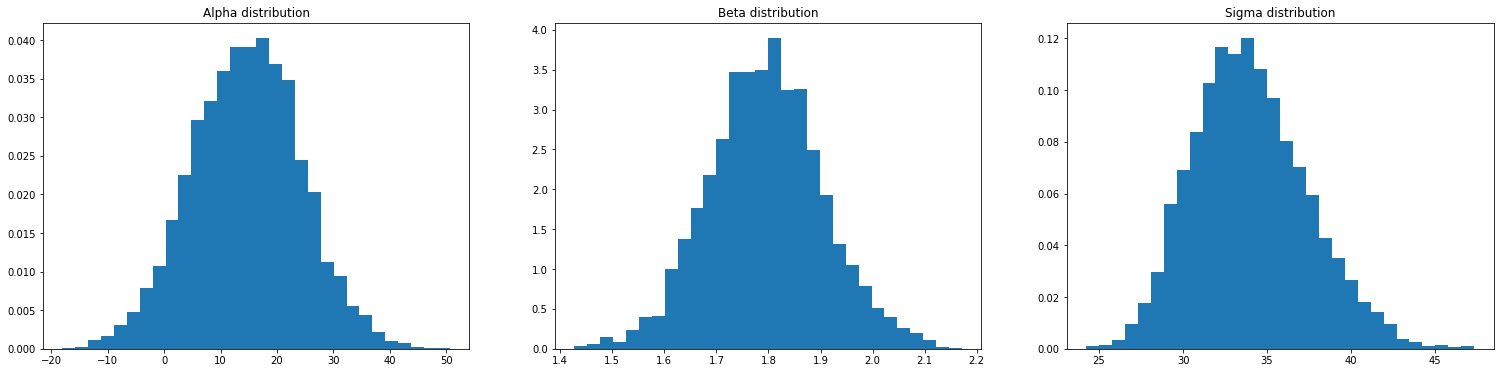

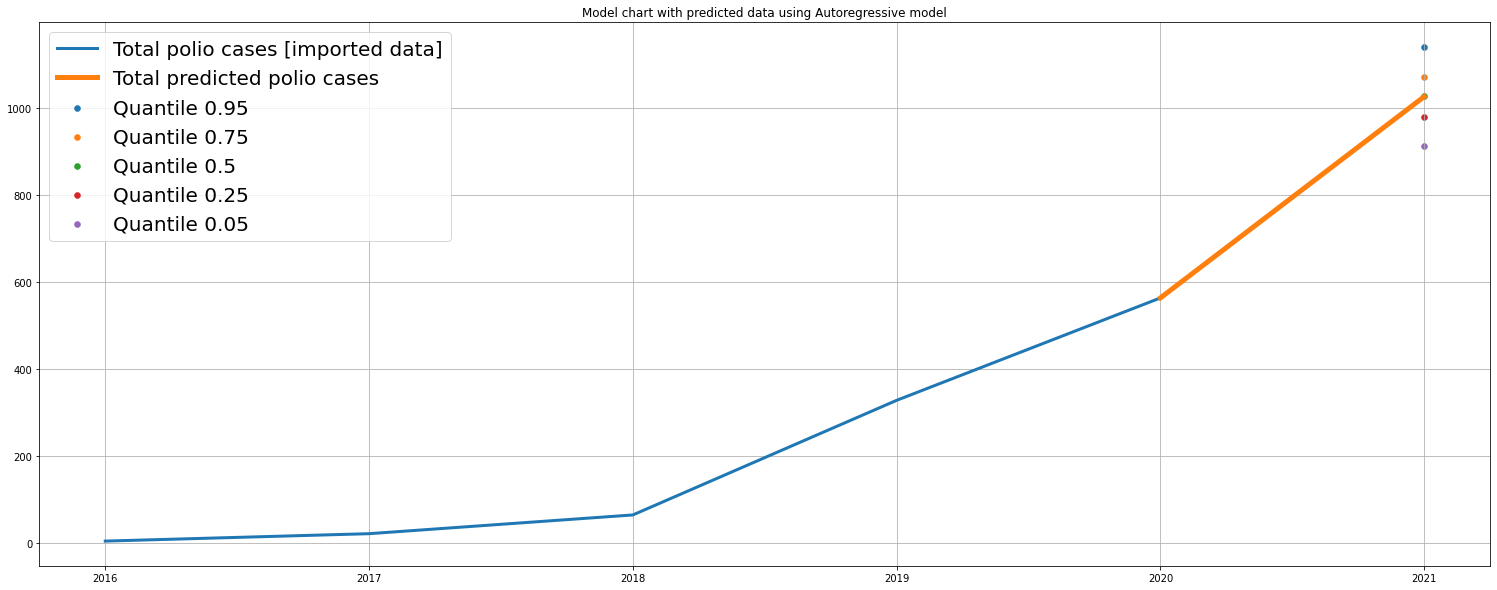

Predicted mean value of Polio cases for year 2021: 1025


In [21]:
model_data_dict = {'N': len(selected_data_growths['Year']),
                    'x': selected_data_growths['Year'],
                    'y': selected_data_growths['Cases'],
                    'x_pred': selected_data_growths['Year'][-1] + 1}

fit_autoregressive_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_growths)
plot_predictions_chart(selected_data_growths, fit_autoregressive_growths.stan_variable('y_pred'), 2021, type='Autoregressive')

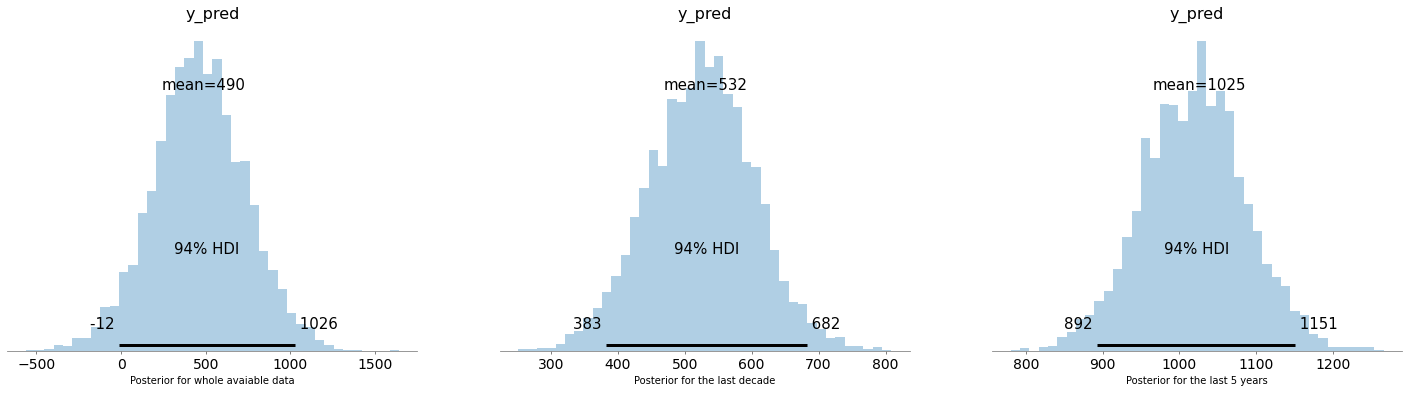

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

<h2>Models comparisons</h2>

<h3>Predictions comparison</h3>
<h4>Whole avaiable data</h4>

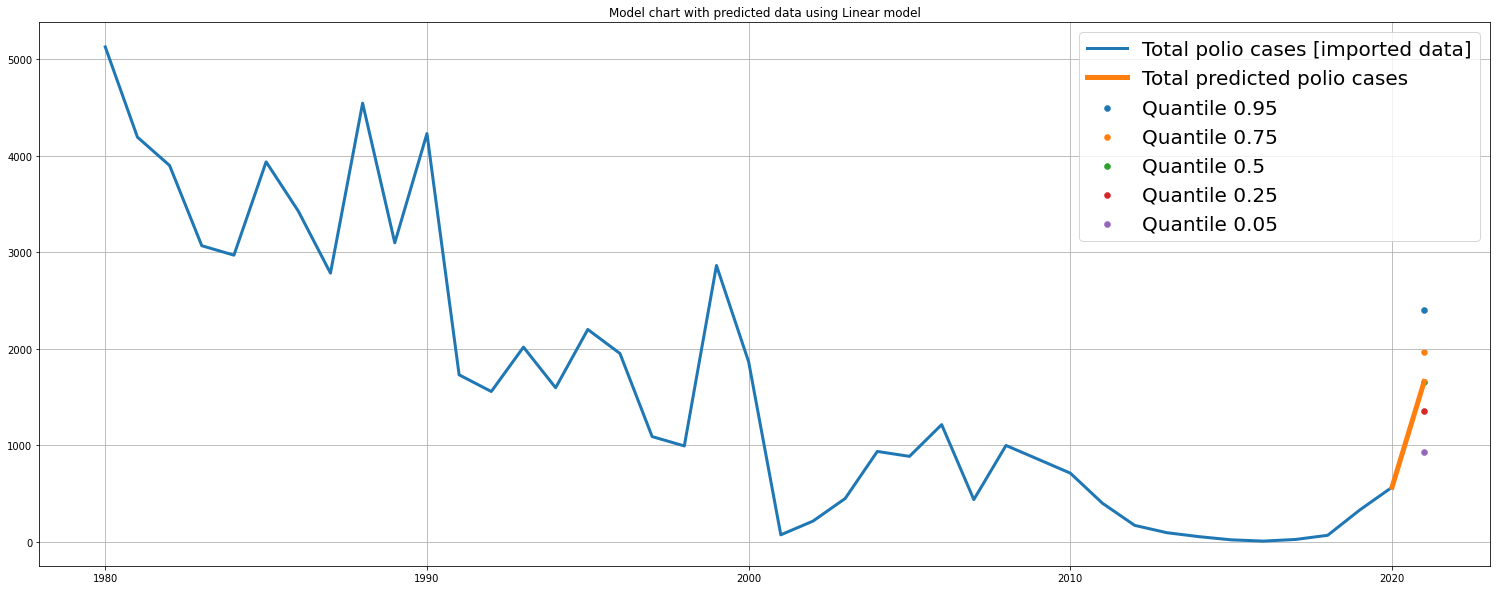

Predicted mean value of Polio cases for year 2021: 1658


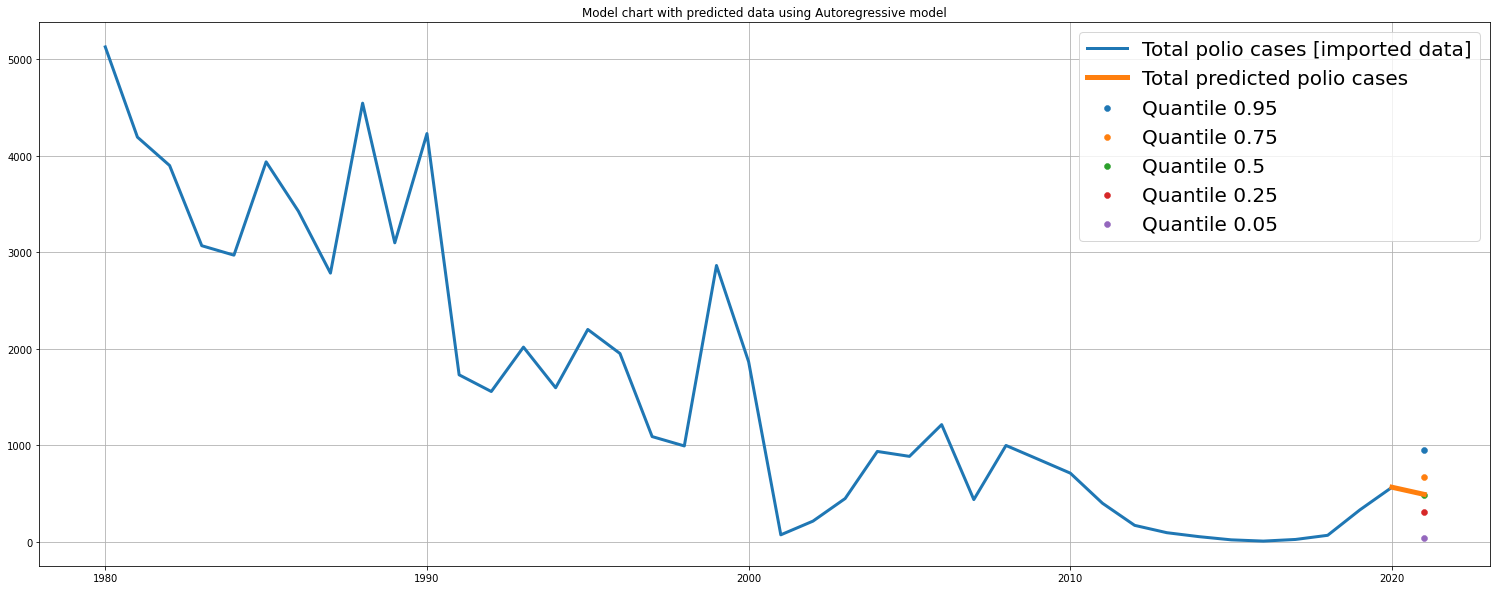

Predicted mean value of Polio cases for year 2021: 489


In [23]:
plot_predictions_chart(selected_data_whole, fit_linear_whole.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_whole, fit_autoregressive_whole.stan_variable('y_pred'), 2021, type='Autoregressive')

<h4>Last decade</h4>

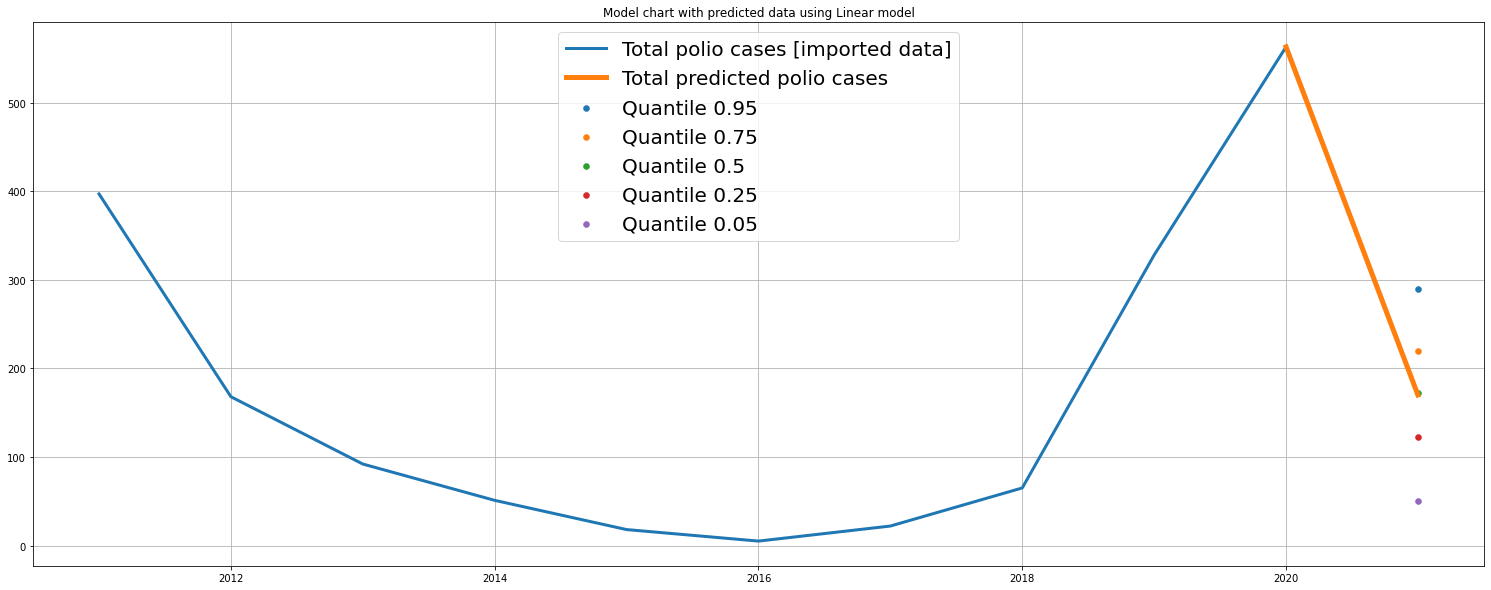

Predicted mean value of Polio cases for year 2021: 170


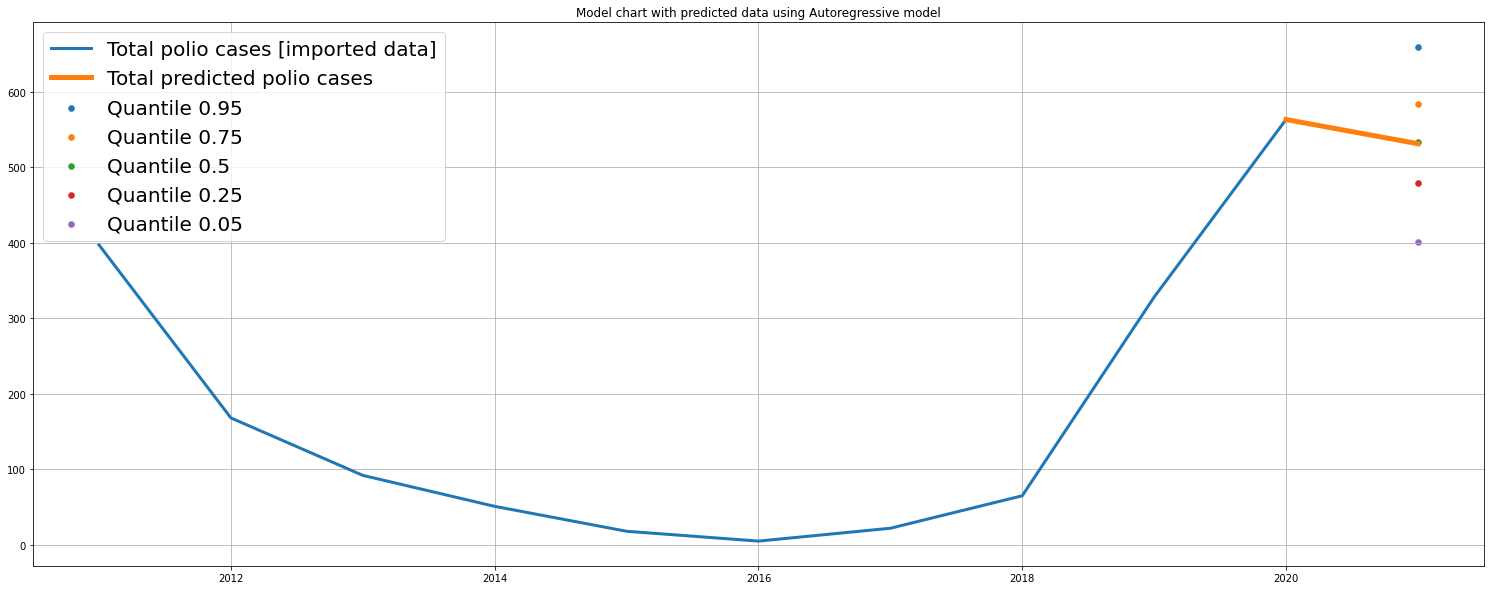

Predicted mean value of Polio cases for year 2021: 531


In [24]:
plot_predictions_chart(selected_data_decade, fit_linear_decade.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_decade, fit_autoregressive_decade.stan_variable('y_pred'), 2021, type='Autoregressive')

<h4>Last 5 years (growths)</h4>

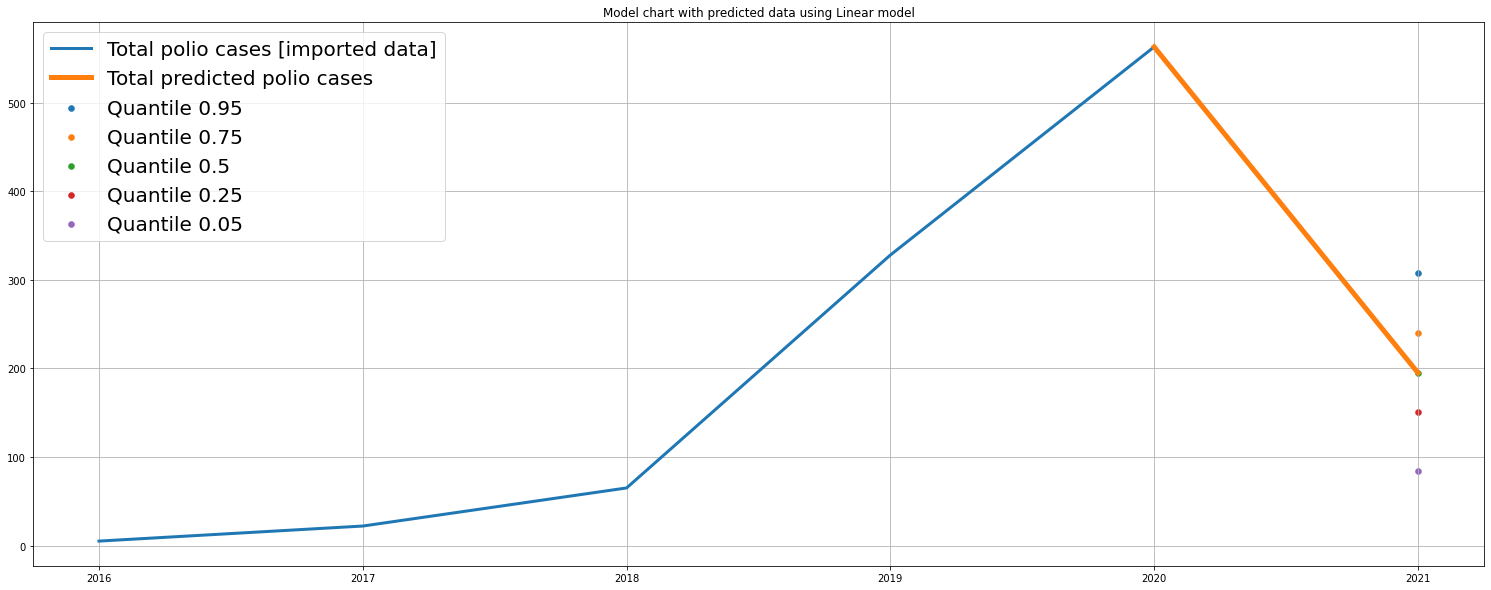

Predicted mean value of Polio cases for year 2021: 195


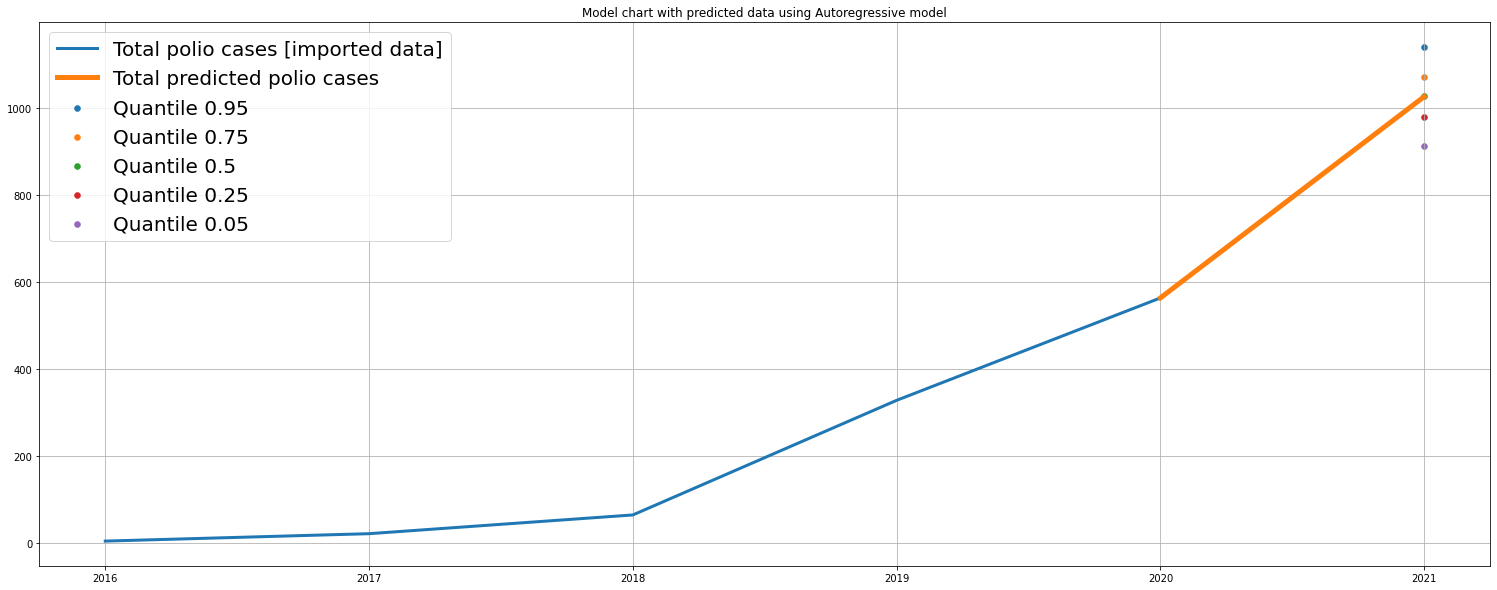

Predicted mean value of Polio cases for year 2021: 1025


In [25]:
plot_predictions_chart(selected_data_growths, fit_linear_growths.stan_variable('y_pred'), 2021, type='Linear')
plot_predictions_chart(selected_data_growths, fit_autoregressive_growths.stan_variable('y_pred'), 2021, type='Autoregressive')

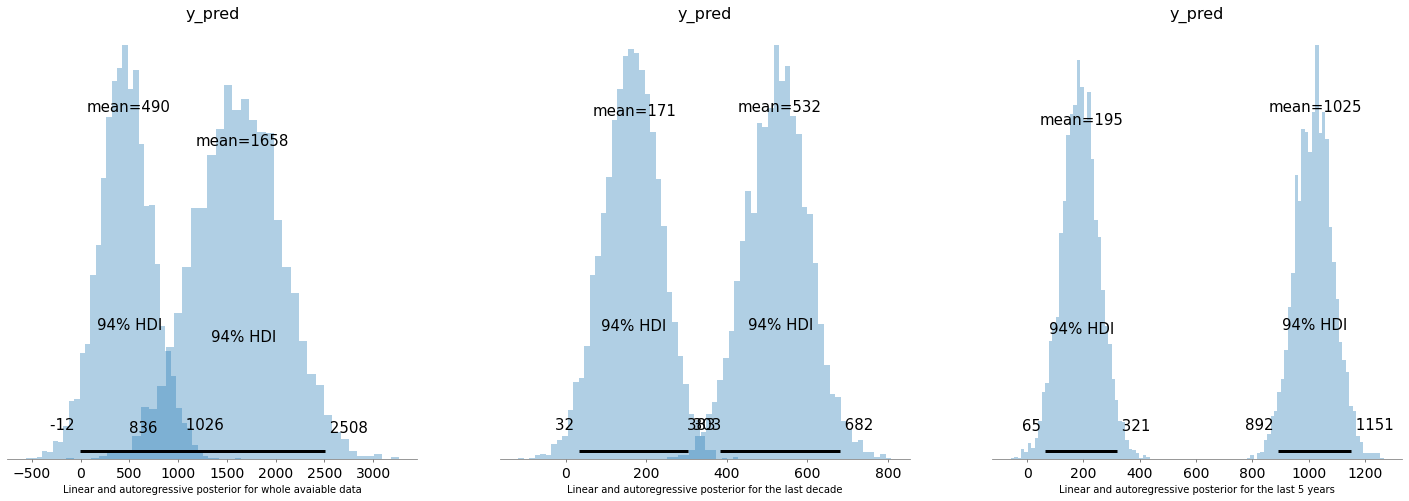

MEAN VALUES:
Linear whole data:  1658
Autoregressive whole data:  489 

Linear last decade:  170
Autoregressive last decade:  531 

Linear last 5 years:  195
Autoregressive last 5 years:  1025 



In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,8))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Linear and autoregressive posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Linear and autoregressive posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Linear and autoregressive posterior for the last 5 years');
plt.show()
print('MEAN VALUES:')
print('Linear whole data: ', int(np.mean(fit_linear_whole.stan_variable('y_pred'))))
print('Autoregressive whole data: ', int(np.mean(fit_autoregressive_whole.stan_variable('y_pred'))), '\n')
print('Linear last decade: ', int(np.mean(fit_linear_decade.stan_variable('y_pred'))))
print('Autoregressive last decade: ', int(np.mean(fit_autoregressive_decade.stan_variable('y_pred'))), '\n')
print('Linear last 5 years: ', int(np.mean(fit_linear_growths.stan_variable('y_pred'))))
print('Autoregressive last 5 years: ', int(np.mean(fit_autoregressive_growths.stan_variable('y_pred'))), '\n')

c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData

                      rank           loo         p_loo         d_loo  weight  \
Autoregressive model     0 -7.327643e+33  7.327643e+33  0.000000e+00     0.5   
Linear model             1 -1.533802e+35  1.533802e+35  1.460525e+35     0.5   

                       se  dse  warning loo_scale  
Autoregressive model  0.0  0.0     True       log  
Linear model          0.0  0.0     True       log  


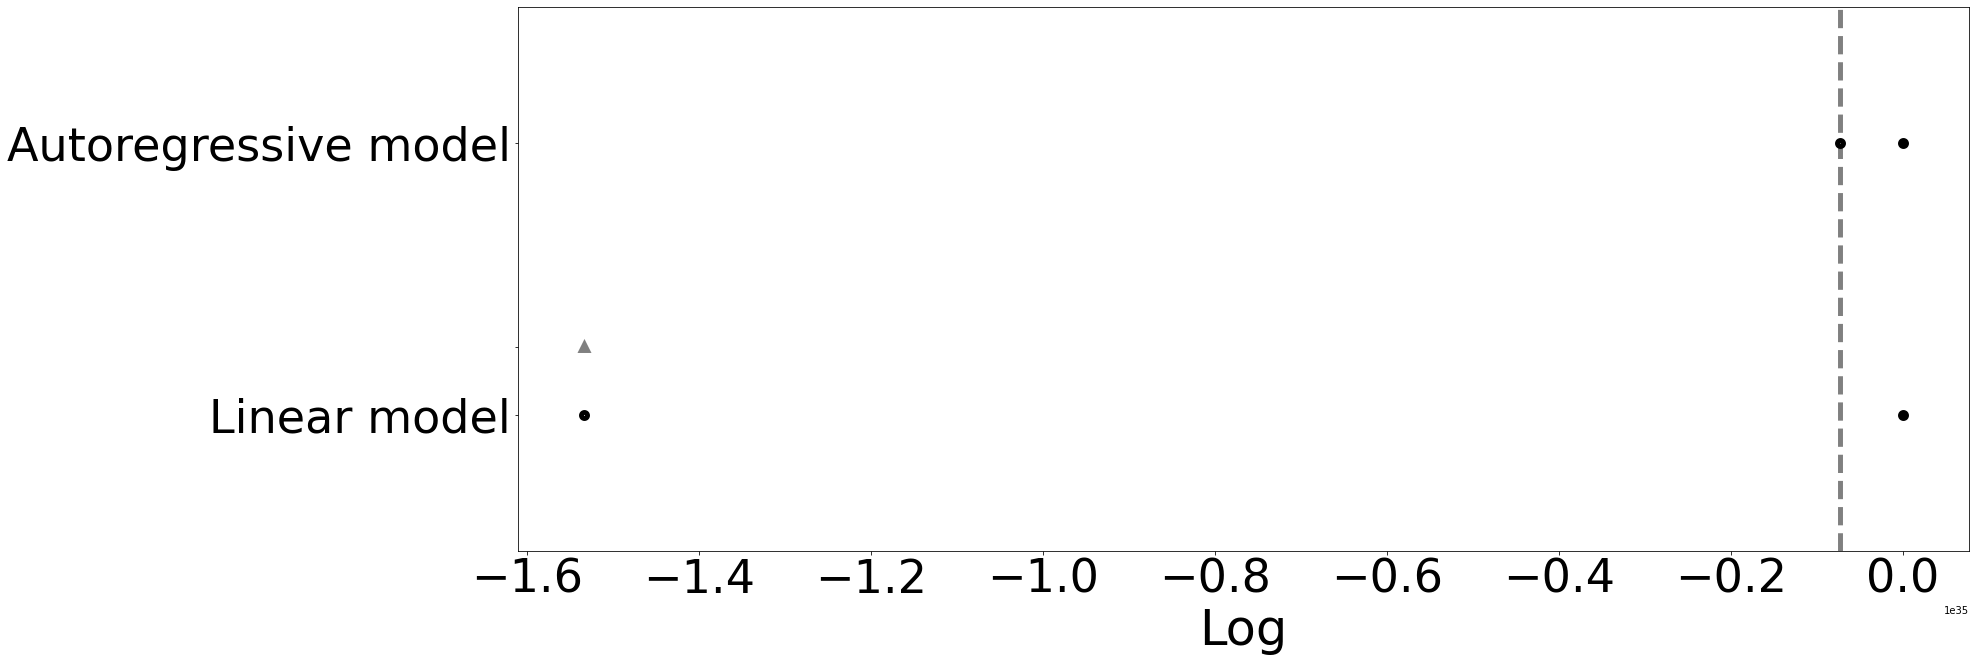

In [27]:
compare_dict = {"Linear model": fit_linear_whole, "Autoregressive model": fit_autoregressive_whole}
comparison = az.compare(compare_dict)
print(comparison)
az.plot_compare(comparison, figsize=(26, 10))
plt.show()